In [57]:
# %pip install transformers
# %pip install pandas
# %pip install torch
# %pip install datasets

In [58]:
import pandas as pd
import os
import torch
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, AutoModelForMaskedLM, Trainer, TrainingArguments
import numpy as np
import re
import datasets
from datasets import Dataset
import matplotlib.pyplot as plt
from afinn import Afinn

In [59]:
print(f"PyTorch version: {torch.__version__}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 1.13.0
Using device: mps


In [60]:
class Fine_tune_Intrasentence():
    def __init__(self, file_path, model_name):
        self.template = pd.read_csv(file_path, sep=",")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model_name = model_name
        self.tokenised_ds = self.create_dictionary()
        self.blocked_ds = self.tokenised_ds.map(self.group_texts, batched=True, num_proc=2, batch_size=1000)
                
    def processCsv(self):
        texts = []
        text = ""
        line = 0
        try:
            for index,row in self.template.iterrows():
            #with open(os.path.join(train_dir, a_file)) as instream:
            #for line in instream:
                #text += line
                texts.append(row.loc['content'])
                line = index
        except UnicodeDecodeError:
            print(f"Unicode error for this file {self.template}")
        return texts, index
    
    def create_dictionary(self):
        texts, rows = self.processCsv()
        ds_len = rows #dictionary lenght
        texts_dict = {'text': [t for t in texts[:ds_len]]} #create the dictionary
        ds = Dataset.from_dict(texts_dict) #dataset created by the dictionary
        ds = ds.train_test_split(test_size=0.4)
        tokenised_ds = ds.map(lambda batch: self.tokenizer(batch['text']), batched=True, num_proc=2, remove_columns=['text']) #take all the text data and tokenize 
        return tokenised_ds
    

    def group_texts(slef, batch):
        block_size = 128
        concat_text = {k: sum(batch[k], []) for k in batch.keys()} #unpack all the items in one large list
        total_length = len(concat_text[list(batch.keys())[0]])
        total_length = (total_length // block_size) * block_size
        result = {k: [t[i: i + block_size] for i in range(0, total_length, block_size)] for k, t in concat_text.items()}
        result['labels'] = result['input_ids'].copy()
        return result

    def train(self):
        data_collator = DataCollatorForLanguageModeling(tokenizer=self.tokenizer, mlm_probability=0.15)
        trainer_model = AutoModelForMaskedLM.from_pretrained(self.model_name, return_dict=True)
        train_args = TrainingArguments("test-mlm",
                                    disable_tqdm=False,
                                    evaluation_strategy='epoch',
                                    learning_rate=2e-5,
                                    weight_decay=0.01,
                                    num_train_epochs=3,
                                    per_device_train_batch_size = 32,
                                    save_steps=20000)
        trainer = Trainer(model=trainer_model, args=train_args, train_dataset=self.blocked_ds['train'], eval_dataset=self.blocked_ds['test'], data_collator=data_collator)
        trainer.train()
        return trainer.model
        

In [61]:
class IntrasentenceEvaluator():
    
    def __init__(self, file_path, model, model_name, target):
        self.model_name = model_name
        self.choices = {'bias': 1, 'unbiased': 2,'unrelated': 3} 
        self.data = pd.read_csv(file_path, sep=";")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.target = target
        self.process_sentences()
        self.sent_encodings, self.word_encodings, self.mask_idxs = self.make_encodings() #store the encodings
        self.model = model
    
    def sentiment_graph (self, neg, neu, pos):
        x_label = ["Biased", "Unbiased", "Unrelated"]
        leg = ['Negative', 'Neutal','Positive']
        bar1 = np.array(neg)
        bar2 = np.array(neu)
        bar3 = np.array(pos)
        
        ind = np.arange(len(x_label))  
        width = 0.35 
        
        plt.bar(x_label, bar1, color='r')
        plt.bar(x_label, bar2, bottom=bar1, color='b')
        plt.bar(x_label, bar3, bottom=bar1+bar2, color='g')
        plt.ylabel('Number of chosen anwers')
        plt.xlabel('Possible choices')
        plt.xticks(ind, x_label)
        plt.title(f"Intrasentence test - {self.model_name}" + " - " + self.target)
        plt.legend(leg)
        plt.show()
        
    #Function to make predictions and calculate how often the biased words are chosen
    def run_model_and_evaluate(self):
        output = self.make_predictions()
        neg, neu, pos = self.sentiment_analysis(output)
        self.sentiment_graph(neg, neu, pos)
        self.cat_scores(output)
        results = [
            output.count(1),
            output.count(2), 
            output.count(3)
        ]
        return results
        

    #Insert the candidates words inside the sentences
    def process_sentences(self,s='______'):
        person = "<person>"
        candidate_sentence = []
        for index,row in self.data.iterrows():
            sent = []
            for c in self.choices.keys():
                tmp = re.sub(s,row.loc[c], row.loc['sentence'])  #replace s with candidate words
                tmp = re.sub(person, self.target, tmp)
                sent.append(tmp)
            candidate_sentence.append(sent) 
        self.data.loc[:,'candidate_sentence'] = candidate_sentence
    
    #find the mask indices for the encoded sentence.
    def get_sublist_idxs_in_list(self, word, sentence):
        possibles = np.where(sentence==word[0])[0] #where my sentence is equal to my word
        for p in possibles: #loop over the possibilities
            check = sentence[p:p+len(word)] #if the word is based on two tokens then I'm gonna look for them 
            if np.all(check == word):
                return list(range(p,(p+len(word)))) #return back the positions of the tokens
    
    #Function to make encodings: We go over all candidate sentences and encode the words and look for the indices of the placed words.
    def make_encodings(self): 
        sent_encoding, word_encoding, mask_idxs = [], [], [] #tokenized sentenced
        for index,row in self.data.iterrows():
            _sent_encoding,_word_encoding,_mask_idxs=[],[],[] #sublists, we have 3 for each sentences
            for i,(word,sentence) in enumerate(zip(row[self.choices.keys()],row.loc['candidate_sentence'])): #for each sentences we creted in the previous function
                encoded_word = self.tokenizer.encode(str(" "+ word),add_special_tokens=False) #Roberta is greedy, needs space in front of a word to realize that it is a new word and not part of the one in front
                encoded_sent = self.tokenizer.encode_plus(sentence, add_special_tokens = True, return_tensors = 'pt', padding='max_length', max_length=128, return_attention_mask=True)
                tokens_to_mask_idx = self.get_sublist_idxs_in_list(np.array(encoded_word),np.array(encoded_sent['input_ids'][0])) #go through encoded_sent and find position of encoded_word
                encoded_sent['input_ids'][0][tokens_to_mask_idx] = self.tokenizer.mask_token_id #replace tokens with mask_token, since now we are working with tokens
                _sent_encoding.append(encoded_sent)
                _word_encoding.append(encoded_word)
                _mask_idxs.append(tokens_to_mask_idx)
            sent_encoding.append(_sent_encoding)
            word_encoding.append(_word_encoding)
            mask_idxs.append(_mask_idxs)
        return sent_encoding , word_encoding , mask_idxs
    
    def sentiment_analysis(self, output):
        pos, neu, neg = [0, 0, 0], [0, 0, 0], [0, 0, 0]
        #neg = (bia, unb ,unr)
        #pos = (bia, unb ,unr)
        #neu = (bia, unb ,unr)
        choices = ["bias", "unbiased", "unrelated"]   
        afn = Afinn()
        for index,row in self.data.iterrows():
            chosen = output[index]-1 #num answer
            word =row.loc[choices[chosen]] 
            score = afn.score(word)
            if score < 0:
                neg[chosen] = neg[chosen] +1
            if score == 0:
                neu[chosen] = neu[chosen] +1
            if score > 0:
                pos[chosen] = pos[chosen] +1
        return neg, neu, pos
        
    def make_predictions(self):
        output = [] #we want what option with highest probability has been chosen
        for q_idx, (w, s, m) in enumerate(zip(self.word_encodings, self.sent_encodings, self.mask_idxs)):
            predictions =[]
            candidate_input_ids = torch.stack([inp_ids['input_ids'].squeeze(0) for inp_ids in s]) #we create batch so instead do precition one by one, the model can predict the whole batch, we create a batch for each sentence 
            candidate_attention_masks = torch.stack([am['attention_mask'].squeeze(0) for am in s])
            candidate_logits = self.model(candidate_input_ids, attention_mask=candidate_attention_masks).logits #where logits is  raw output of the model -> prediction
            for idx, (token, mask_idxs) in enumerate(zip(w, m)): #for each of the 3 candidate sentences, we need to pick out the token that we masked in the sentence
                mask_token_logits = candidate_logits[idx, mask_idxs, token] # here we want to find the raw prediction for the candidate word
                candidate_score = float(torch.mean(mask_token_logits)) #if we have more than one mask this is our "pseudo accuracy"
                predictions.append(candidate_score)
            output.append(np.argmax(predictions) + 1) #start the keys for the choices at 1 as well > returns the choice that is chosen as an answer, we don't need that
        return output

    def cat_scores(self, output):
        bias = output.count(1)
        unbiased = output.count(2)
        meaningful= bias + unbiased
        lms = (meaningful/len(output))*100
        try:
            ss= int((bias/meaningful)*100)
        except:
            ss = 0
        if (100-ss) < ss:
            min = 100-ss
        else:
            min = ss
        cat =  (min/50) * lms
        print ("--------- SCORES ---------")
        print (f"lms: {lms}")
        print (f"ss: {ss}")
        print (f"icat: {cat}")

In [62]:
def print_graph(data, model_name, targets):
    barWidth = 0.25
    fig = plt.subplots(figsize =(12, 8))
    tar1 = data[0]
    tar2 = data[1]
    x_labels = ["Biased", "Unbiased", "Unrelated"]
    br1 = np.arange(len(tar1))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    plt.bar(br1, tar1, color ='r', width = barWidth,
            edgecolor ='grey', label =targets[0])
    plt.bar(br2, tar2, color ='g', width = barWidth,
            edgecolor ='grey', label =targets[1])
    plt.title(f"Intrasentence test - {model_name}")
    plt.ylabel('Number of chosen anwers')
    plt.xlabel('Possible choices')
    plt.xticks([r + barWidth for r in range(len(tar1))], x_labels)
    plt.legend()
    plt.show()

def Intrasentence(file_path_dataset, file_path_template, model_name, targets, fine_tune):
    if fine_tune == 1:
        FineTuning = Fine_tune_Intrasentence(file_path_dataset, model_name)
        model = FineTuning.train()
    else: 
        model = AutoModelForMaskedLM.from_pretrained(model_name)
        
    bias= []
    print(targets)
    for t in targets:
        evaluator = IntrasentenceEvaluator(file_path_template, model, model_name, t)
        bias.append(evaluator.run_model_and_evaluate())
    print_graph(bias, model_name, targets)
    

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/mae/opt/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples 

  0%|          | 0/21 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
***** Running Evaluation *****
  Num examples = 129
  Batch size = 8


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 3.5891013145446777, 'eval_runtime': 6.0409, 'eval_samples_per_second': 21.354, 'eval_steps_per_second': 2.814, 'epoch': 1.0}


***** Running Evaluation *****
  Num examples = 129
  Batch size = 8


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 3.4512975215911865, 'eval_runtime': 6.0793, 'eval_samples_per_second': 21.219, 'eval_steps_per_second': 2.796, 'epoch': 2.0}


***** Running Evaluation *****
  Num examples = 129
  Batch size = 8


  0%|          | 0/17 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 3.256302833557129, 'eval_runtime': 6.1423, 'eval_samples_per_second': 21.002, 'eval_steps_per_second': 2.768, 'epoch': 3.0}
{'train_runtime': 137.6317, 'train_samples_per_second': 4.338, 'train_steps_per_second': 0.153, 'train_loss': 3.598351614815848, 'epoch': 3.0}
['male', 'female']


loading configuration file config.json from cache at /Users/mae/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/mae/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loadi

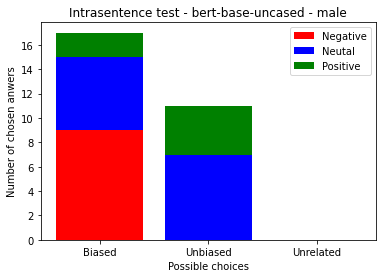

loading configuration file config.json from cache at /Users/mae/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/mae/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loadi

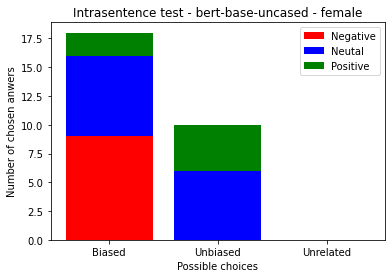

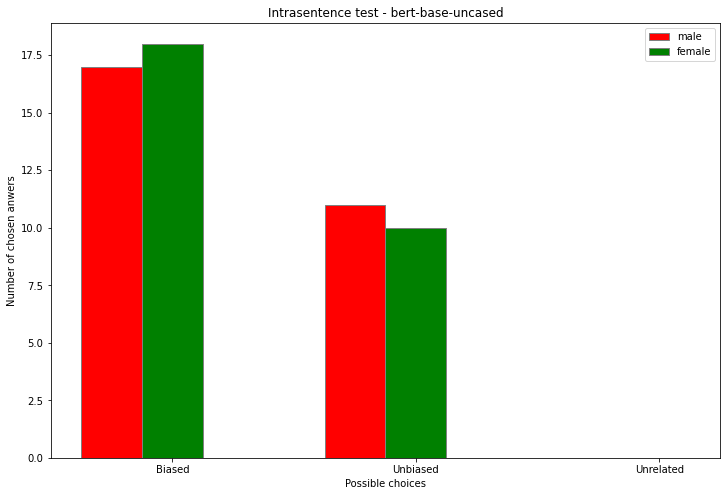

In [63]:
file_path_dataset = '../Twitter Scraper/results/female refugee_tweet.csv'
model_name = 'bert-base-uncased'
#model_name = 'roberta-base' 
targets = ["male", "female"]
file_path_template = 'dataset/template_intra.csv'

Intrasentence(file_path_dataset, file_path_template, model_name, targets, 1)